In [14]:
import numpy as np
import pickle as pickle
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from typing import Optional, List
from moseq2_nlp.models import DocumentEmbedding
from moseq2_nlp.data import load_groups, get_embedding_representation, get_transition_representation
from moseq2_nlp.train import train_regressor, train_svm
from moseq2_viz.util import parse_index
from moseq2_viz.model.util import (get_transition_matrix,
                                   parse_model_results,
                                   results_to_dataframe,
                                   relabel_by_usage, get_syllable_statistics)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from scipy.spatial.distance import pdist,squareform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelBinarizer
import pdb
from collections import OrderedDict
from tqdm import tqdm
from tqdm import trange

import warnings
warnings.filterwarnings('ignore') 


https://github.com/dattalab/moseq-drugs
https://www.nature.com/articles/s41593-020-00706-3.pdf

In [4]:
data_dir = '/home/mgricci/data/abraira/moseq-drugs'
fns = ['dataset.pkl','fingerprints.pkl','syllablelabels.pkl']
content_dict = {'dataset':None, 'fingerprints':None, 'syllables':None}

for key, fn in zip(content_dict.keys(),fns):
    full_path = os.path.join(data_dir,fn)
    with open(full_path, 'rb') as pickle_file:
        content_dict[key] = pickle.load(pickle_file, encoding='latin1')

In [5]:
# Plotting 
def make_label(feature_type):
    return f'{feature_type} F1: {np.mean(f1s[feature_type]):.2f} ± {np.std(f1s[feature_type])/np.sqrt(n_labels):.2f}'

feature_color = {
    'Scalars': '#B4AD33',
    'Usages': '#7C449A',
    'Shuffled': '#7C449A',
    'Transitions':'#FF796C',
    'DM':'#C5C9C7',
    'CBOW':'#06C2AC',
    'Combined':'#7BC8F6'
}

feature_mark = {
    'Scalars': '-',
    'Usages': '-',
    'Shuffled': '--',
    'Transitions':'-',
    'DM':'-',
    'CBOW':'-',
    'Combined':'-'
}

In [6]:
fingerprints, fingerprint_labels = content_dict['fingerprints']

label_level = 'dose' # also valid: class, dose
feature_types = ['moseq', 'scalars', 'shuffled_moseq']
y = fingerprint_labels[f'y_{label_level}']
unique_labels = fingerprint_labels[f'unique_{label_level}']
n_labels = len(unique_labels)


NameError: name 'LabelBinarizer' is not defined

In [7]:
# Load the labels into our dataset array
split_points = np.cumsum([len(v['data']) for v in content_dict['dataset'].values()])[:-1]
split_syllable_labels = np.array_split(content_dict['syllables'],split_points)
for mouse_name,_syllable_labels in zip(content_dict['dataset'].keys(),split_syllable_labels):
    content_dict['dataset'][mouse_name]['syllable_labels'] = _syllable_labels

In [8]:
split_syllable_labels = np.where(np.isnan(split_syllable_labels), -5, split_syllable_labels)
# Get rid of bad syllables
split_syllable_labels = split_syllable_labels[:,3:]
num_syllables = len(np.unique(split_syllable_labels))

# Data

In [10]:
# Raw data
sentences = []
emissions = []
for ssl in split_syllable_labels:
    sentence = np.array([int(s) for s in ssl])
    cp_inds = np.concatenate((np.where(np.diff(sentence) != 0 )[0],np.array([len(sentence) - 1])))
    emissions.append(sentence[cp_inds])
    sentences.append([str(e) for e in sentence[cp_inds]])

In [11]:
# Usages
U = content_dict['fingerprints'][0]['moseq']
num_syllables = U.shape[1]

In [38]:
# Transitions
num_transitions = -1
T = []
for em in emissions:
    T.append(get_transition_matrix([em], combine=True, max_syllable = U.shape[1] - 1).reshape(-1))
T = np.array(T)
# top_transitions = np.argsort(T.mean(0))[-max_transitions:]
sorted_inds = np.argsort(T.mean(0))
sorted_tm_vals = T[:,sorted_inds]
if num_transitions < 0:
    tm_sums = list(sorted_tm_vals.sum(0))
    first_zero = num_syllables**2 - next((i for i, x in enumerate(tm_sums) if x), None)
    truncated_tm_vals = sorted_tm_vals[:,:first_zero]
else:
    truncated_tm_vals = sorted_tm_vals[:,:num_transitions]
T = truncated_tm_vals

In [40]:
documents = [TaggedDocument(sent, [i]) for i, sent in enumerate(sentences)]

In [41]:
dim = num_syllables #300 #max_syllable # Dimension of embedding space
window = 4 # Window size for context (this is left and right, so total size is 2*window)

# Initialize and train two models on the documents. Embeddings will be averaged, which is standard. 
# Note: min_count = <min_count> omits words with usages less than <min_count>
print('Training dm=1')
model1 = Doc2Vec(documents, dm=1, epochs=250, vector_size=dim, window=window, min_count=1, workers=1, negative=200)
print('Training dm=0')
model2 = Doc2Vec(documents, dm=0, epochs=250, vector_size=dim, window=window, min_count=1, workers=1, negative=num_syllables-1)
print('Done')

Training dm=1


KeyboardInterrupt: 

In [12]:
# Infer embeddings per document per model and then average. 
print('Inferring E1')
E1 = [model1.infer_vector(sent) for sent in sentences]
print('Inferring E2')
E2 = [model2.infer_vector(sent) for sent in sentences]
E = [.5 * (em1 + em2) for (em1, em2) in zip(E1, E2)]

Inferring E1
Inferring E2


In [13]:
E1 = np.array(E1)
E2 = np.array(E2)
E  = np.array(E)
all_reps = [fingerprints[ft] for ft in feature_types] + [T, E1, E2, E]
all_rep_names = ['Usages', 'Scalars', 'Shuffled', 'Transitions', 'DM', 'CBOW', 'Combined']

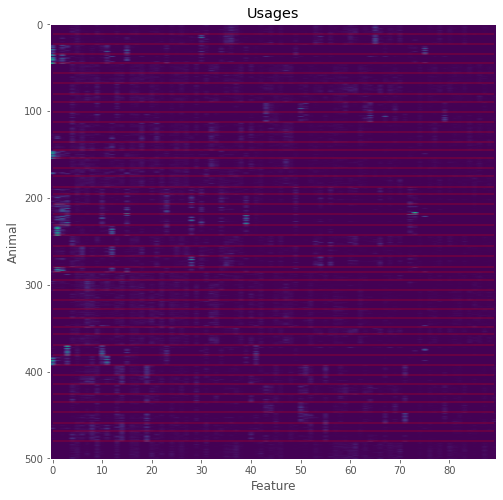

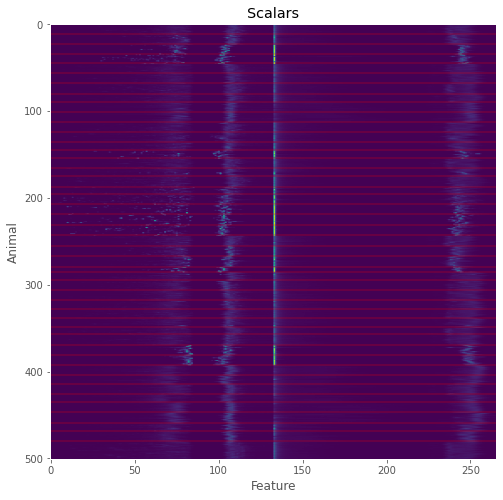

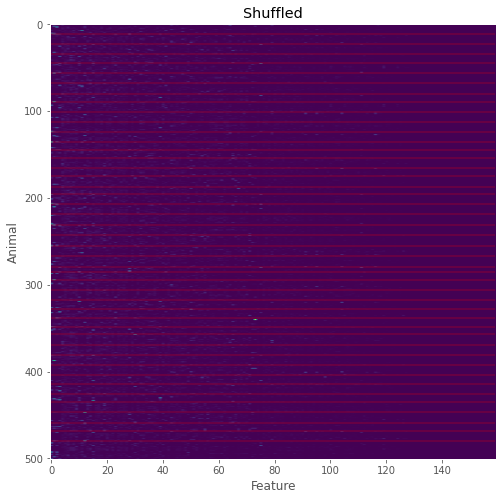

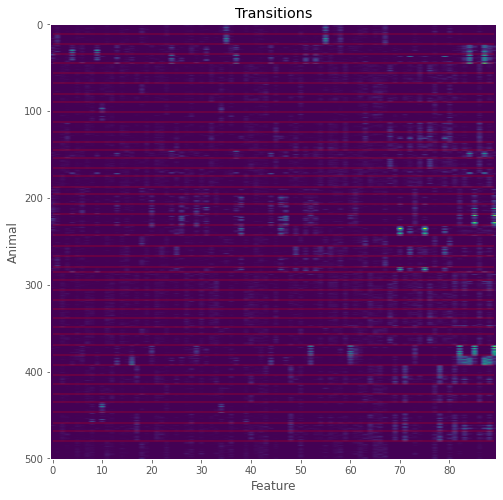

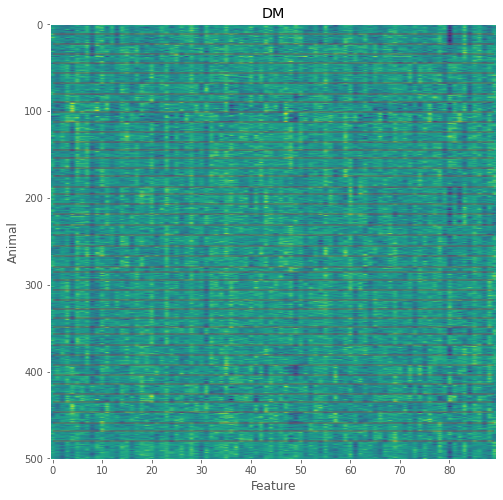

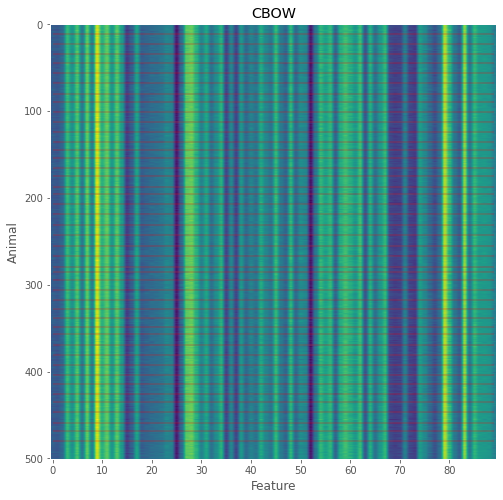

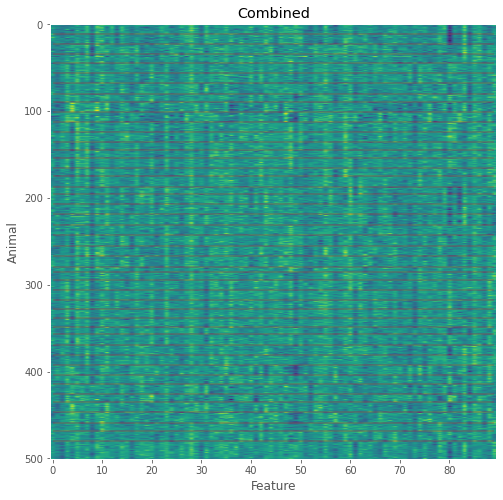

In [14]:
for nm, rep in zip(all_rep_names, all_reps):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(rep, aspect='auto')
    ax.set_title(f'{nm}')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Animal')
    ax.grid(False)
    lb_cps = np.where(np.diff(y)!=0)[0]
    for lbc in lb_cps:
        ax.hlines(y=lbc, xmin=0, xmax=rep.shape[1] - 1, color='r', linestyle='-',alpha=.25)
plt.show()
plt.close()

## Visualize

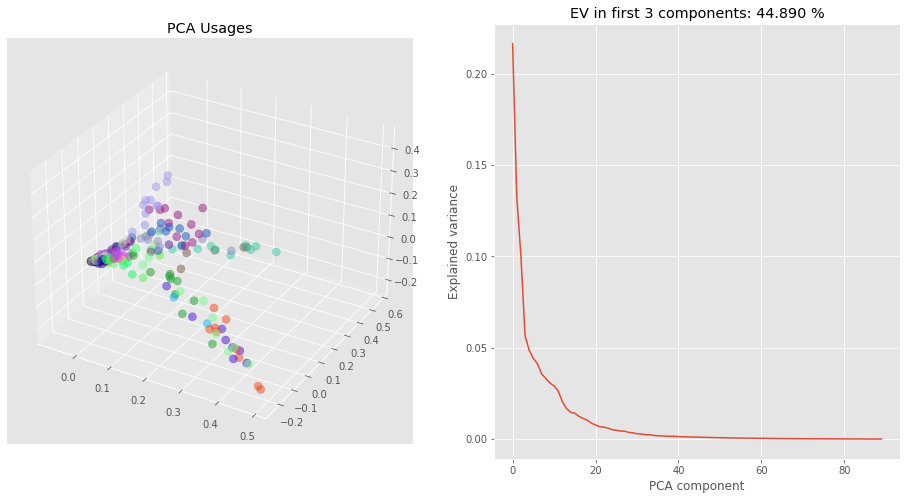

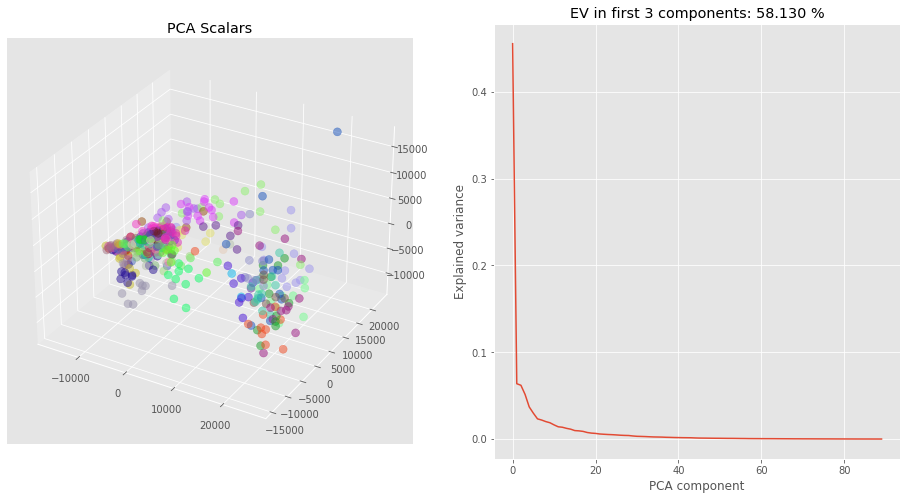

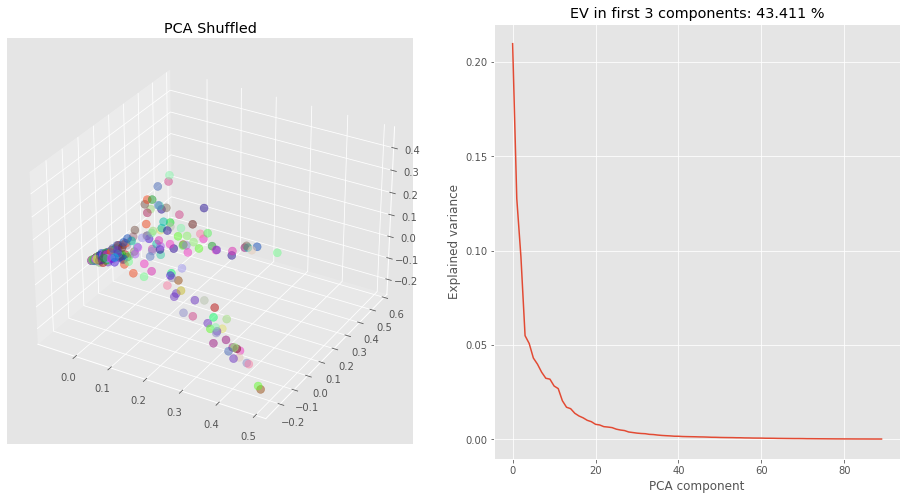

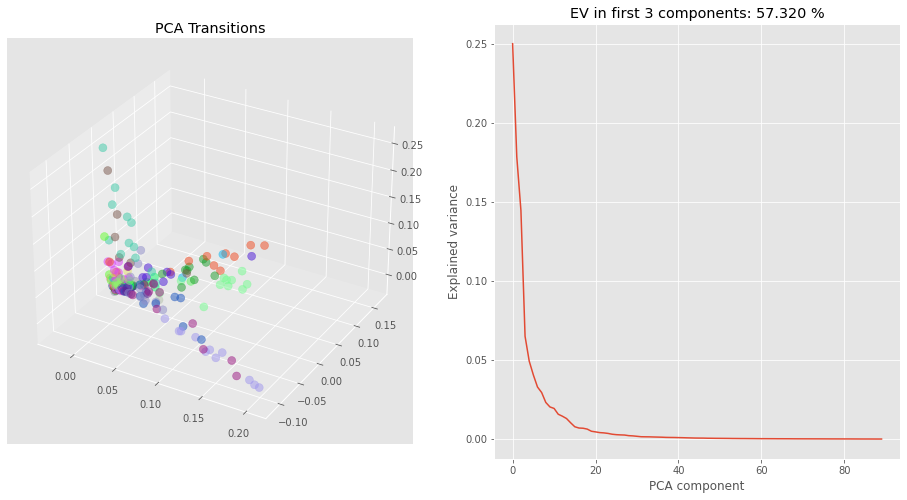

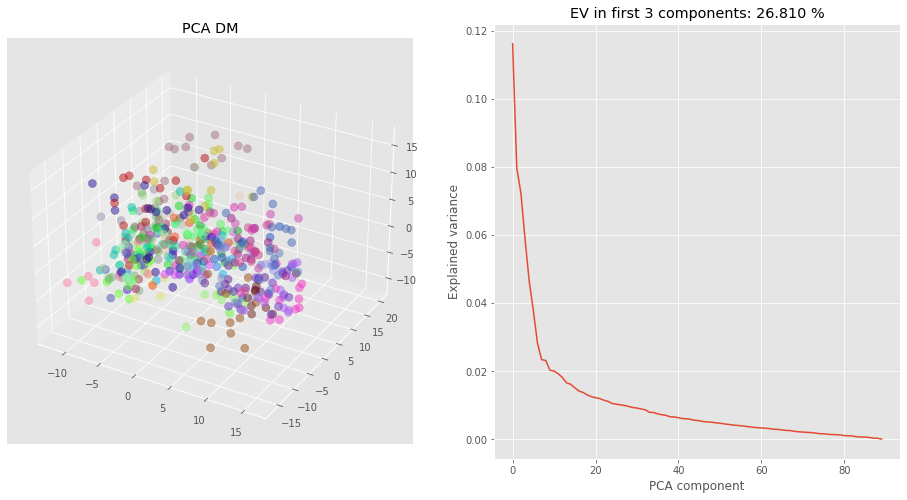

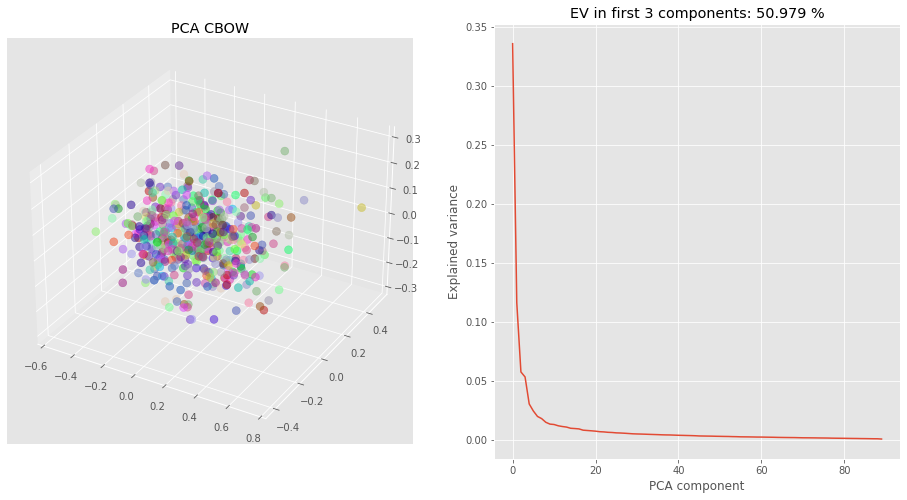

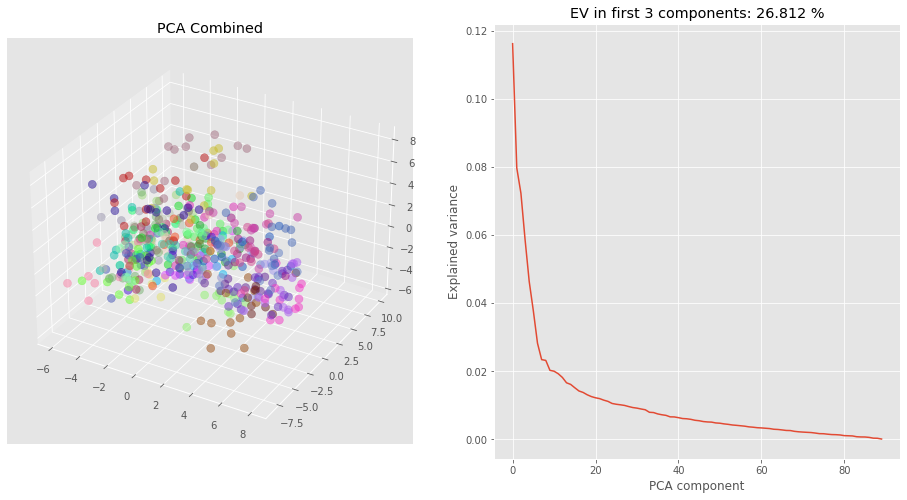

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
which_model = 'pca'
n_components = 3

unique_colors = np.random.rand(len(unique_labels),3)
colors = [unique_colors[lb] for lb in y]

for nm, rep in zip(all_rep_names, all_reps):

    if which_model == 'pca':
        model = PCA(n_components=num_syllables)
    else:
        model = TSNE(n_components=n_components, perplexity=150)
    out = model.fit_transform(rep)
    fig = plt.figure(figsize=(16,8))
    
    if n_components == 2:
        ax = fig.add_subplot(1, 2, 1)
        ax.scatter(out[:,0], out[:,1],c=colors, alpha=.5)

    elif n_components > 2:
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.scatter(out[:,0], out[:,1], out[:,2],c=colors, s=64, alpha=.5)
    else:
        print('Need more dimensions!')
    ax.set_title(f'PCA {nm}')
    
    if which_model == 'pca':
        ax = fig.add_subplot(1, 2, 2)
        normalized_ev = model.explained_variance_/model.explained_variance_.sum()
        ax.plot(normalized_ev)
        perc_exp = normalized_ev[:n_components].sum() * 100
        ax.set_xlabel('PCA component')
        ax.set_ylabel('Explained variance')
        ax.set_title(f'EV in first {n_components} components: {perc_exp:.3f} %')
    plt.show()
    plt.close()

In [16]:
# Train/Test split
from moseq2_nlp.train import train_regressor
num_animals = U.shape[0]
test_size=.5
K=1
penalty='l2'
num_c=5
seed=0
multi_class='ovr'
verbose=0
split_seed=0

In [17]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
for nm, rep in zip(all_rep_names[-3:], all_reps[-3:]):
    print(nm)
    X_train, X_test, y_train, y_test = train_test_split(rep, y, test_size=test_size, random_state=split_seed, stratify=y)
    clf = train_regressor(X_train, y_train, K, penalty, num_c, seed, multi_class, verbose)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(report)


DM
              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       0.50      0.33      0.40         6
           2       0.30      0.50      0.37         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.17      0.33      0.22         6
           6       0.14      0.17      0.15         6
           7       0.25      0.25      0.25         4
           8       0.75      0.50      0.60         6
           9       1.00      0.67      0.80         6
          10       0.08      0.17      0.11         6
          11       0.38      0.83      0.53         6
          12       0.22      0.50      0.31         4
          13       0.00      0.00      0.00         4
          14       0.29      0.33      0.31         6
          15       0.17      0.25      0.20         4
          16       0.00      0.00      0.00         6
          17       0.25 

Text(0.5, 1.0, 'Drug+Dose classification')

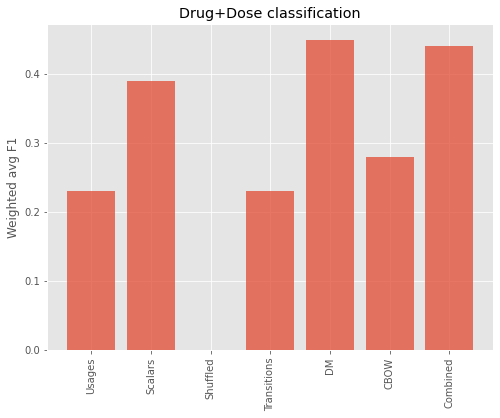

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
weighted_avgs = [.23,.39, .00, .23, .45, .28, .44]
ax.bar(range(len(all_rep_names)), weighted_avgs, alpha=.75)
ax.set_xticklabels([''] + all_rep_names, rotation=90)
ax.set_ylabel('Weighted avg F1')
ax.set_title('Drug+Dose classification')

In [115]:
cross_validate_C=Tryue
n_samples = 25
precisions = OrderedDict(())
recalls = OrderedDict(())
f1s = OrderedDict(())

for x, nm in zip(all_reps, all_rep_names):
    print(f'Working on {nm}')
    
    f1s[nm] = []
    all_true_labels = []
    all_scores = []
    
    for iseed in trange(n_samples):
        true_labels, pred_labels, scores = train_linear_classifier(x, y, seed=iseed, cross_validate_C=cross_validate_C)
        all_true_labels.append(label_binarizer.transform(true_labels))
        all_scores.append(scores)
        
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[nm].append(per_label_f1)
  
    precisions[nm], recalls[nm], _ = precision_recall_curve(
        np.array(all_true_labels).ravel(), np.array(all_scores).ravel()
    )
    f1s[nm] = np.mean(f1s[nm], axis=0) # average over seeds



Working on Usages


100%|███████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.42it/s]


Working on Scalars


100%|███████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.06it/s]


Working on Shuffled


100%|███████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.13it/s]


Working on Transitions


100%|███████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  8.35it/s]


Working on DM


100%|███████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.32it/s]


Working on CBOW


100%|███████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Working on Combined


100%|███████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.36it/s]


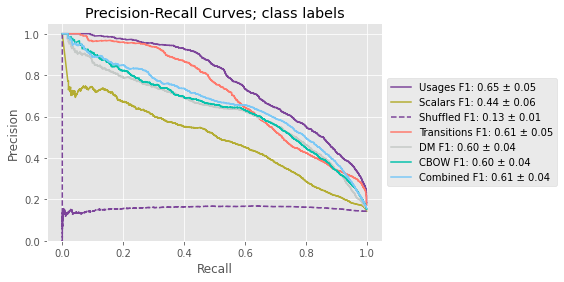

In [116]:
for nm in all_rep_names:
    label = make_label(nm)
    plt.plot(recalls[nm], precisions[nm],
         label=label, color=feature_color[nm], 
         linestyle=feature_mark[nm])
plt.title(f'Precision-Recall Curves; {label_level} labels')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1.05)
plt.legend(loc='center left', bbox_to_anchor=[1,0.5])
plt.show()
plt.close()